https://docs.google.com/document/d/103yulQ3ILCKRoh4ws1oCnSoT54MJQuDS8-nth6l_6GY/edit

### Face mask detecion - prototype

Mateusz Hryciów

Kacper Zagórski

Mateusz Szewczyk

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import time

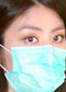

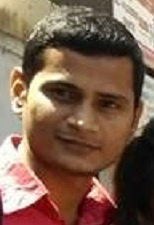

In [17]:
from PIL import Image
display(Image.open('./dataset/with_mask/0_0_0 copy 10.jpg'))
display(Image.open('./dataset/without_mask/1.jpg'))

In [18]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [19]:
train_data = datasets.ImageFolder('./dataset',transform=train_transform)
test_data = datasets.ImageFolder('./dataset',transform=test_transform)

In [20]:
np.random.seed(10)
class_names = train_data.classes

num_train = len(train_data)
indices = list(range(num_train))
split = int(np.floor(0.2 * num_train))

np.random.seed(1)
np.random.shuffle(indices)
train_idx, test_idx = indices[split:], indices[:split]

#balanced sampling (against the classes) + taking only the train_idx
train_sampler = SubsetRandomSampler(train_idx) 
test_sampler = SubsetRandomSampler(test_idx)

In [7]:
print(len(train_idx))
len(test_idx)

3094


773

In [10]:
batch_size = 100 #only to display images, trained with batch = 100
workers = 0

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, sampler=train_sampler, num_workers=workers)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, sampler=test_sampler, num_workers=workers)

Class: ['with_mask', 'with_mask', 'with_mask', 'without_mask', 'without_mask', 'with_mask', 'without_mask', 'without_mask', 'without_mask', 'with_mask']


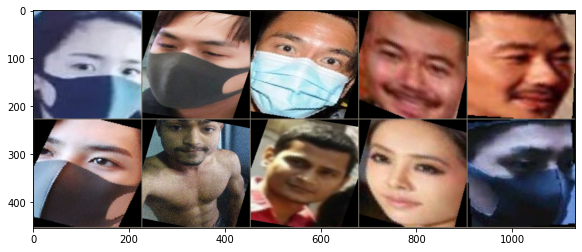

In [9]:
for images,labels in train_loader: 
    break

print('Class:', [class_names[i] for i in labels])

im = make_grid(images, nrow=5)
# denormalizacja obrazow, żeby widok był przyjemny dla oka
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)
plt.figure(figsize=(12,4))
# imshow wymaga podania wymiarów w innej kolejności
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

In [21]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        #(in_chan, out_chan, size, stride, padding)
        self.conv1 = nn.Conv2d(3, 16, 10, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 20, 3, 1)
        # parameter - dropout probability
        self.dropout1 = nn.Dropout(0.5)
        #(((200-2)/2) - 2)/2 = 48.5; zaokrąglone w dół
        self.fc1 = nn.Linear(9*9*32, 200)
        self.fc2 = nn.Linear(200, 80)
        self.fc3 = nn.Linear(80, 2)

    def forward(self, X):
        X = F.relu(self.conv1(X)) #rectified linear unit - activation function
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = self.dropout1(X)
        X = X.view(-1, 9*9*32) 
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1) # converting logits to odds

In [22]:
CNNmodel = ConvolutionalNetwork()

In [23]:
CNNmodel.parameters

<bound method Module.parameters of ConvolutionalNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(10, 10), stride=(3, 3), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(20, 20), stride=(3, 3), padding=(1, 1))
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=2592, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=2, bias=True)
)>

In [63]:
def train_model(CNNmodel, criterion, optimizer, epochs):
    start_time = time.time()

    train_losses = []
    test_losses = []
    train_correct = []
    test_correct = []

    for i in range(epochs):
        trn_corr = 0
        tst_corr = 0

        for b,(X_train,y_train) in enumerate(train_loader):

            b+=1

            # predykcja
            y_pred = CNNmodel(X_train)
            # strata
            loss = criterion(y_pred, y_train)
            
            # przewidywana klasa
            predicted = torch.max(y_pred,1)[1]
            # liczba poprawnych predykcji
            batch_corr = (predicted == y_train).sum()
            trn_corr += batch_corr

            # zerowanie gradientu
            optimizer.zero_grad()
            # propagacja wsteczna
            loss.backward()
            # uaktualnienie parametrów
            optimizer.step()
            
#             if b%10 == 0:
            print(f'Epoka: {i}, seria: {b}, strata: {loss}, dokładność: {trn_corr.item()/b:7.3f}%')

        train_losses.append(loss)
        train_correct.append(trn_corr)

        # testowanie po każdej iteracji
        with torch.no_grad():
            for b, (X_test, y_test) in enumerate(test_loader):

                y_val = CNNmodel(X_test)

                predicted = torch.max(y_val,1)[1]
                tst_corr += (predicted == y_test).sum()

        loss = criterion(y_val, y_test)
        test_losses.append(loss)
        test_correct.append(tst_corr)

    total_time = (time.time() - start_time)/60
    
    print(f'Czas uczenia: {total_time} minut.')
    
    return CNNmodel, train_losses, test_losses, train_correct, test_correct

In [100]:
criterion = nn.CrossEntropyLoss()
CNNmodel = ConvolutionalNetwork()
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.00001)

In [101]:
result = train_model(CNNmodel, criterion, optimizer, 100)

CNNmodel,train_losses, test_losses, train_correct, test_correct = result

Epoka: 0, seria: 1, strata: 0.6946197748184204, dokładność:  49.000%
Epoka: 0, seria: 2, strata: 0.6930397152900696, dokładność:  48.500%
Epoka: 0, seria: 3, strata: 0.6949771046638489, dokładność:  47.333%
Epoka: 0, seria: 4, strata: 0.6951318979263306, dokładność:  45.750%
Epoka: 0, seria: 5, strata: 0.6958125829696655, dokładność:  43.400%
Epoka: 0, seria: 6, strata: 0.6848732829093933, dokładność:  46.167%
Epoka: 0, seria: 7, strata: 0.6925367116928101, dokładność:  45.857%
Epoka: 0, seria: 8, strata: 0.6873786449432373, dokładność:  47.375%
Epoka: 0, seria: 9, strata: 0.687940776348114, dokładność:  48.111%
Epoka: 0, seria: 10, strata: 0.6838220953941345, dokładność:  50.000%
Epoka: 0, seria: 11, strata: 0.6880614757537842, dokładność:  50.636%
Epoka: 0, seria: 12, strata: 0.6869757771492004, dokładność:  51.083%
Epoka: 0, seria: 13, strata: 0.687913179397583, dokładność:  50.846%
Epoka: 0, seria: 14, strata: 0.6836632490158081, dokładność:  51.643%
Epoka: 0, seria: 15, strata: 0.

Epoka: 3, seria: 26, strata: 0.31832873821258545, dokładność:  88.385%
Epoka: 3, seria: 27, strata: 0.30908480286598206, dokładność:  88.333%
Epoka: 3, seria: 28, strata: 0.36657091975212097, dokładność:  88.250%
Epoka: 3, seria: 29, strata: 0.26175355911254883, dokładność:  88.276%
Epoka: 3, seria: 30, strata: 0.3060675859451294, dokładność:  88.333%
Epoka: 3, seria: 31, strata: 0.2732626795768738, dokładność:  88.226%
Epoka: 4, seria: 1, strata: 0.3037545382976532, dokładność:  91.000%
Epoka: 4, seria: 2, strata: 0.3938327431678772, dokładność:  88.000%
Epoka: 4, seria: 3, strata: 0.2219175547361374, dokładność:  89.667%
Epoka: 4, seria: 4, strata: 0.2931840717792511, dokładność:  89.250%
Epoka: 4, seria: 5, strata: 0.24873551726341248, dokładność:  89.800%
Epoka: 4, seria: 6, strata: 0.31472086906433105, dokładność:  89.667%
Epoka: 4, seria: 7, strata: 0.31533944606781006, dokładność:  89.286%
Epoka: 4, seria: 8, strata: 0.3565680980682373, dokładność:  88.750%
Epoka: 4, seria: 9, s

Epoka: 7, seria: 19, strata: 0.32791638374328613, dokładność:  88.947%
Epoka: 7, seria: 20, strata: 0.14303641021251678, dokładność:  89.350%
Epoka: 7, seria: 21, strata: 0.27576279640197754, dokładność:  89.476%
Epoka: 7, seria: 22, strata: 0.46857544779777527, dokładność:  89.182%
Epoka: 7, seria: 23, strata: 0.24261623620986938, dokładność:  89.304%
Epoka: 7, seria: 24, strata: 0.19045019149780273, dokładność:  89.542%
Epoka: 7, seria: 25, strata: 0.20180360972881317, dokładność:  89.720%
Epoka: 7, seria: 26, strata: 0.25810253620147705, dokładność:  89.692%
Epoka: 7, seria: 27, strata: 0.2913895845413208, dokładność:  89.593%
Epoka: 7, seria: 28, strata: 0.30125653743743896, dokładność:  89.571%
Epoka: 7, seria: 29, strata: 0.3434429168701172, dokładność:  89.517%
Epoka: 7, seria: 30, strata: 0.18076352775096893, dokładność:  89.667%
Epoka: 7, seria: 31, strata: 0.17122110724449158, dokładność:  89.548%
Epoka: 8, seria: 1, strata: 0.20143365859985352, dokładność:  92.000%
Epoka: 8,

Epoka: 11, seria: 12, strata: 0.3068332374095917, dokładność:  88.833%
Epoka: 11, seria: 13, strata: 0.18219701945781708, dokładność:  89.154%
Epoka: 11, seria: 14, strata: 0.1957327127456665, dokładność:  89.286%
Epoka: 11, seria: 15, strata: 0.3576258718967438, dokładność:  89.000%
Epoka: 11, seria: 16, strata: 0.20793691277503967, dokładność:  89.250%
Epoka: 11, seria: 17, strata: 0.185632586479187, dokładność:  89.353%
Epoka: 11, seria: 18, strata: 0.24653120338916779, dokładność:  89.556%
Epoka: 11, seria: 19, strata: 0.1856260895729065, dokładność:  89.684%
Epoka: 11, seria: 20, strata: 0.30267876386642456, dokładność:  89.600%
Epoka: 11, seria: 21, strata: 0.5018593668937683, dokładność:  89.095%
Epoka: 11, seria: 22, strata: 0.20580753684043884, dokładność:  89.182%
Epoka: 11, seria: 23, strata: 0.2095152884721756, dokładność:  89.304%
Epoka: 11, seria: 24, strata: 0.2007538378238678, dokładność:  89.542%
Epoka: 11, seria: 25, strata: 0.21917304396629333, dokładność:  89.680%
E

Epoka: 15, seria: 3, strata: 0.2709009647369385, dokładność:  89.000%
Epoka: 15, seria: 4, strata: 0.21060290932655334, dokładność:  90.000%
Epoka: 15, seria: 5, strata: 0.21687452495098114, dokładność:  90.200%
Epoka: 15, seria: 6, strata: 0.17110148072242737, dokładność:  90.833%
Epoka: 15, seria: 7, strata: 0.2299119383096695, dokładność:  91.000%
Epoka: 15, seria: 8, strata: 0.2340518832206726, dokładność:  91.375%
Epoka: 15, seria: 9, strata: 0.20137713849544525, dokładność:  91.556%
Epoka: 15, seria: 10, strata: 0.23201671242713928, dokładność:  91.600%
Epoka: 15, seria: 11, strata: 0.15250371396541595, dokładność:  91.727%
Epoka: 15, seria: 12, strata: 0.21987058222293854, dokładność:  91.667%
Epoka: 15, seria: 13, strata: 0.26412081718444824, dokładność:  91.538%
Epoka: 15, seria: 14, strata: 0.24086879193782806, dokładność:  91.571%
Epoka: 15, seria: 15, strata: 0.23015417158603668, dokładność:  91.600%
Epoka: 15, seria: 16, strata: 0.16489152610301971, dokładność:  91.812%
Ep

Epoka: 18, seria: 25, strata: 0.1512005627155304, dokładność:  91.280%
Epoka: 18, seria: 26, strata: 0.2481600046157837, dokładność:  91.423%
Epoka: 18, seria: 27, strata: 0.18532995879650116, dokładność:  91.556%
Epoka: 18, seria: 28, strata: 0.2465147227048874, dokładność:  91.571%
Epoka: 18, seria: 29, strata: 0.22150039672851562, dokładność:  91.552%
Epoka: 18, seria: 30, strata: 0.19399887323379517, dokładność:  91.500%
Epoka: 18, seria: 31, strata: 0.2482443004846573, dokładność:  91.290%
Epoka: 19, seria: 1, strata: 0.16814319789409637, dokładność:  92.000%
Epoka: 19, seria: 2, strata: 0.19903339445590973, dokładność:  92.500%
Epoka: 19, seria: 3, strata: 0.1407923847436905, dokładność:  94.000%
Epoka: 19, seria: 4, strata: 0.14302514493465424, dokładność:  93.750%
Epoka: 19, seria: 5, strata: 0.22528934478759766, dokładność:  93.800%
Epoka: 19, seria: 6, strata: 0.21039606630802155, dokładność:  94.000%
Epoka: 19, seria: 7, strata: 0.29619330167770386, dokładność:  93.143%
Epok

Epoka: 22, seria: 16, strata: 0.22810930013656616, dokładność:  92.312%
Epoka: 22, seria: 17, strata: 0.21991223096847534, dokładność:  92.294%
Epoka: 22, seria: 18, strata: 0.29585734009742737, dokładność:  92.111%
Epoka: 22, seria: 19, strata: 0.14716878533363342, dokładność:  92.211%
Epoka: 22, seria: 20, strata: 0.19899879395961761, dokładność:  92.200%
Epoka: 22, seria: 21, strata: 0.22970211505889893, dokładność:  92.000%
Epoka: 22, seria: 22, strata: 0.27335768938064575, dokładność:  91.955%
Epoka: 22, seria: 23, strata: 0.24121589958667755, dokładność:  91.826%
Epoka: 22, seria: 24, strata: 0.25934699177742004, dokładność:  91.750%
Epoka: 22, seria: 25, strata: 0.14452701807022095, dokładność:  91.880%
Epoka: 22, seria: 26, strata: 0.19015489518642426, dokładność:  91.923%
Epoka: 22, seria: 27, strata: 0.1858796328306198, dokładność:  92.000%
Epoka: 22, seria: 28, strata: 0.3009413778781891, dokładność:  91.929%
Epoka: 22, seria: 29, strata: 0.13648469746112823, dokładność:  92

Epoka: 26, seria: 7, strata: 0.1697595715522766, dokładność:  91.857%
Epoka: 26, seria: 8, strata: 0.1827755719423294, dokładność:  91.875%
Epoka: 26, seria: 9, strata: 0.1729169487953186, dokładność:  92.222%
Epoka: 26, seria: 10, strata: 0.14695799350738525, dokładność:  92.300%
Epoka: 26, seria: 11, strata: 0.2376118302345276, dokładność:  92.091%
Epoka: 26, seria: 12, strata: 0.1625833362340927, dokładność:  92.250%
Epoka: 26, seria: 13, strata: 0.22931189835071564, dokładność:  92.308%
Epoka: 26, seria: 14, strata: 0.2690615952014923, dokładność:  92.143%
Epoka: 26, seria: 15, strata: 0.17627863585948944, dokładność:  92.067%
Epoka: 26, seria: 16, strata: 0.3121364414691925, dokładność:  91.688%
Epoka: 26, seria: 17, strata: 0.24661651253700256, dokładność:  91.706%
Epoka: 26, seria: 18, strata: 0.20172086358070374, dokładność:  91.889%
Epoka: 26, seria: 19, strata: 0.25792717933654785, dokładność:  91.789%
Epoka: 26, seria: 20, strata: 0.2587350904941559, dokładność:  91.650%
Epo

Epoka: 29, seria: 29, strata: 0.22974757850170135, dokładność:  92.310%
Epoka: 29, seria: 30, strata: 0.1989433467388153, dokładność:  92.300%
Epoka: 29, seria: 31, strata: 0.16131368279457092, dokładność:  92.161%
Epoka: 30, seria: 1, strata: 0.2516951262950897, dokładność:  90.000%
Epoka: 30, seria: 2, strata: 0.22025619447231293, dokładność:  91.000%
Epoka: 30, seria: 3, strata: 0.18841858208179474, dokładność:  91.667%
Epoka: 30, seria: 4, strata: 0.2419174313545227, dokładność:  91.250%
Epoka: 30, seria: 5, strata: 0.1257428526878357, dokładność:  92.400%
Epoka: 30, seria: 6, strata: 0.2537728250026703, dokładność:  91.667%
Epoka: 30, seria: 7, strata: 0.21510650217533112, dokładność:  91.143%
Epoka: 30, seria: 8, strata: 0.26520487666130066, dokładność:  91.125%
Epoka: 30, seria: 9, strata: 0.13603715598583221, dokładność:  91.889%
Epoka: 30, seria: 10, strata: 0.3155119717121124, dokładność:  91.400%
Epoka: 30, seria: 11, strata: 0.16356511414051056, dokładność:  91.636%
Epoka: 

Epoka: 33, seria: 20, strata: 0.18369537591934204, dokładność:  93.000%
Epoka: 33, seria: 21, strata: 0.1850195825099945, dokładność:  93.048%
Epoka: 33, seria: 22, strata: 0.14801841974258423, dokładność:  93.091%
Epoka: 33, seria: 23, strata: 0.2864840030670166, dokładność:  92.870%
Epoka: 33, seria: 24, strata: 0.21775631606578827, dokładność:  92.792%
Epoka: 33, seria: 25, strata: 0.2223939746618271, dokładność:  92.680%
Epoka: 33, seria: 26, strata: 0.2092188000679016, dokładność:  92.692%
Epoka: 33, seria: 27, strata: 0.15386725962162018, dokładność:  92.778%
Epoka: 33, seria: 28, strata: 0.22668905556201935, dokładność:  92.786%
Epoka: 33, seria: 29, strata: 0.12879982590675354, dokładność:  92.828%
Epoka: 33, seria: 30, strata: 0.20629611611366272, dokładność:  92.833%
Epoka: 33, seria: 31, strata: 0.20111428201198578, dokładność:  92.645%
Epoka: 34, seria: 1, strata: 0.10627869516611099, dokładność:  96.000%
Epoka: 34, seria: 2, strata: 0.2200646996498108, dokładność:  93.000%

Epoka: 37, seria: 11, strata: 0.1334400624036789, dokładność:  92.727%
Epoka: 37, seria: 12, strata: 0.19279807806015015, dokładność:  92.833%
Epoka: 37, seria: 13, strata: 0.14861778914928436, dokładność:  93.000%
Epoka: 37, seria: 14, strata: 0.246976837515831, dokładność:  92.714%
Epoka: 37, seria: 15, strata: 0.2424594759941101, dokładność:  92.600%
Epoka: 37, seria: 16, strata: 0.10830497741699219, dokładność:  92.812%
Epoka: 37, seria: 17, strata: 0.13642162084579468, dokładność:  92.824%
Epoka: 37, seria: 18, strata: 0.16938576102256775, dokładność:  92.944%
Epoka: 37, seria: 19, strata: 0.15044747292995453, dokładność:  92.947%
Epoka: 37, seria: 20, strata: 0.2190411537885666, dokładność:  92.900%
Epoka: 37, seria: 21, strata: 0.22894415259361267, dokładność:  92.905%
Epoka: 37, seria: 22, strata: 0.2684544324874878, dokładność:  92.818%
Epoka: 37, seria: 23, strata: 0.2860635817050934, dokładność:  92.522%
Epoka: 37, seria: 24, strata: 0.25028112530708313, dokładność:  92.375%

Epoka: 41, seria: 2, strata: 0.2188272923231125, dokładność:  93.000%
Epoka: 41, seria: 3, strata: 0.15075351297855377, dokładność:  93.333%
Epoka: 41, seria: 4, strata: 0.1132977232336998, dokładność:  93.750%
Epoka: 41, seria: 5, strata: 0.21801358461380005, dokładność:  93.400%
Epoka: 41, seria: 6, strata: 0.21433517336845398, dokładność:  92.833%
Epoka: 41, seria: 7, strata: 0.1463088095188141, dokładność:  92.857%
Epoka: 41, seria: 8, strata: 0.27416184544563293, dokładność:  92.250%
Epoka: 41, seria: 9, strata: 0.18858566880226135, dokładność:  92.333%
Epoka: 41, seria: 10, strata: 0.16869087517261505, dokładność:  92.400%
Epoka: 41, seria: 11, strata: 0.17629125714302063, dokładność:  92.545%
Epoka: 41, seria: 12, strata: 0.15432222187519073, dokładność:  92.750%
Epoka: 41, seria: 13, strata: 0.19486874341964722, dokładność:  92.923%
Epoka: 41, seria: 14, strata: 0.21223533153533936, dokładność:  92.929%
Epoka: 41, seria: 15, strata: 0.12206380069255829, dokładność:  93.133%
Epo

Epoka: 44, seria: 24, strata: 0.21065235137939453, dokładność:  92.792%
Epoka: 44, seria: 25, strata: 0.16698913276195526, dokładność:  92.880%
Epoka: 44, seria: 26, strata: 0.25992605090141296, dokładność:  92.808%
Epoka: 44, seria: 27, strata: 0.2295795977115631, dokładność:  92.667%
Epoka: 44, seria: 28, strata: 0.14551430940628052, dokładność:  92.679%
Epoka: 44, seria: 29, strata: 0.12535955011844635, dokładność:  92.793%
Epoka: 44, seria: 30, strata: 0.19082708656787872, dokładność:  92.800%
Epoka: 44, seria: 31, strata: 0.12722863256931305, dokładność:  92.677%
Epoka: 45, seria: 1, strata: 0.14559051394462585, dokładność:  95.000%
Epoka: 45, seria: 2, strata: 0.11876078695058823, dokładność:  95.000%
Epoka: 45, seria: 3, strata: 0.2996695637702942, dokładność:  93.000%
Epoka: 45, seria: 4, strata: 0.18245001137256622, dokładność:  92.750%
Epoka: 45, seria: 5, strata: 0.2619313895702362, dokładność:  92.600%
Epoka: 45, seria: 6, strata: 0.20665527880191803, dokładność:  92.833%
E

Epoka: 48, seria: 15, strata: 0.1945098638534546, dokładność:  93.867%
Epoka: 48, seria: 16, strata: 0.1990085244178772, dokładność:  93.875%
Epoka: 48, seria: 17, strata: 0.19963164627552032, dokładność:  93.706%
Epoka: 48, seria: 18, strata: 0.17391076683998108, dokładność:  93.722%
Epoka: 48, seria: 19, strata: 0.13126623630523682, dokładność:  93.842%
Epoka: 48, seria: 20, strata: 0.1531854271888733, dokładność:  93.850%
Epoka: 48, seria: 21, strata: 0.2002859264612198, dokładność:  93.952%
Epoka: 48, seria: 22, strata: 0.14622822403907776, dokładność:  93.864%
Epoka: 48, seria: 23, strata: 0.07365736365318298, dokładność:  94.087%
Epoka: 48, seria: 24, strata: 0.29149410128593445, dokładność:  93.917%
Epoka: 48, seria: 25, strata: 0.16863906383514404, dokładność:  93.800%
Epoka: 48, seria: 26, strata: 0.20027704536914825, dokładność:  93.654%
Epoka: 48, seria: 27, strata: 0.1951930969953537, dokładność:  93.593%
Epoka: 48, seria: 28, strata: 0.21230827271938324, dokładność:  93.46

Epoka: 52, seria: 6, strata: 0.1298111379146576, dokładność:  93.667%
Epoka: 52, seria: 7, strata: 0.18161574006080627, dokładność:  93.286%
Epoka: 52, seria: 8, strata: 0.058559779077768326, dokładność:  94.000%
Epoka: 52, seria: 9, strata: 0.22637252509593964, dokładność:  93.778%
Epoka: 52, seria: 10, strata: 0.11851570010185242, dokładność:  94.200%
Epoka: 52, seria: 11, strata: 0.25535354018211365, dokładność:  93.727%
Epoka: 52, seria: 12, strata: 0.24307040870189667, dokładność:  93.417%
Epoka: 52, seria: 13, strata: 0.2329673320055008, dokładność:  93.385%
Epoka: 52, seria: 14, strata: 0.20261530578136444, dokładność:  93.286%
Epoka: 52, seria: 15, strata: 0.2013242095708847, dokładność:  93.067%
Epoka: 52, seria: 16, strata: 0.1373925656080246, dokładność:  93.312%
Epoka: 52, seria: 17, strata: 0.11298274248838425, dokładność:  93.353%
Epoka: 52, seria: 18, strata: 0.1502971053123474, dokładność:  93.444%
Epoka: 52, seria: 19, strata: 0.11201734840869904, dokładność:  93.526%


Epoka: 55, seria: 28, strata: 0.09349879622459412, dokładność:  93.750%
Epoka: 55, seria: 29, strata: 0.20215560495853424, dokładność:  93.759%
Epoka: 55, seria: 30, strata: 0.1395508050918579, dokładność:  93.800%
Epoka: 55, seria: 31, strata: 0.21128731966018677, dokładność:  93.613%
Epoka: 56, seria: 1, strata: 0.21117570996284485, dokładność:  92.000%
Epoka: 56, seria: 2, strata: 0.13379575312137604, dokładność:  93.500%
Epoka: 56, seria: 3, strata: 0.16731001436710358, dokładność:  92.667%
Epoka: 56, seria: 4, strata: 0.17261652648448944, dokładność:  92.500%
Epoka: 56, seria: 5, strata: 0.13712672889232635, dokładność:  93.000%
Epoka: 56, seria: 6, strata: 0.21808481216430664, dokładność:  92.333%
Epoka: 56, seria: 7, strata: 0.17956216633319855, dokładność:  92.286%
Epoka: 56, seria: 8, strata: 0.12873369455337524, dokładność:  92.625%
Epoka: 56, seria: 9, strata: 0.1921198070049286, dokładność:  92.667%
Epoka: 56, seria: 10, strata: 0.21000848710536957, dokładność:  92.700%
Epo

Epoka: 59, seria: 19, strata: 0.21932575106620789, dokładność:  93.947%
Epoka: 59, seria: 20, strata: 0.13229826092720032, dokładność:  94.100%
Epoka: 59, seria: 21, strata: 0.24337857961654663, dokładność:  93.905%
Epoka: 59, seria: 22, strata: 0.16585180163383484, dokładność:  93.864%
Epoka: 59, seria: 23, strata: 0.0625774934887886, dokładność:  94.087%
Epoka: 59, seria: 24, strata: 0.1265975534915924, dokładność:  94.208%
Epoka: 59, seria: 25, strata: 0.14124783873558044, dokładność:  94.160%
Epoka: 59, seria: 26, strata: 0.160630002617836, dokładność:  94.038%
Epoka: 59, seria: 27, strata: 0.19347244501113892, dokładność:  94.000%
Epoka: 59, seria: 28, strata: 0.11474411934614182, dokładność:  94.000%
Epoka: 59, seria: 29, strata: 0.15834522247314453, dokładność:  93.966%
Epoka: 59, seria: 30, strata: 0.2195768505334854, dokładność:  93.933%
Epoka: 59, seria: 31, strata: 0.14866118133068085, dokładność:  93.742%
Epoka: 60, seria: 1, strata: 0.17695574462413788, dokładność:  96.000

Epoka: 63, seria: 10, strata: 0.15401190519332886, dokładność:  94.500%
Epoka: 63, seria: 11, strata: 0.1482689380645752, dokładność:  94.273%
Epoka: 63, seria: 12, strata: 0.12362203001976013, dokładność:  94.500%
Epoka: 63, seria: 13, strata: 0.10128538310527802, dokładność:  94.692%
Epoka: 63, seria: 14, strata: 0.09028112143278122, dokładność:  94.929%
Epoka: 63, seria: 15, strata: 0.12777386605739594, dokładność:  95.000%
Epoka: 63, seria: 16, strata: 0.0923825353384018, dokładność:  95.125%
Epoka: 63, seria: 17, strata: 0.19759979844093323, dokładność:  94.941%
Epoka: 63, seria: 18, strata: 0.14112070202827454, dokładność:  94.833%
Epoka: 63, seria: 19, strata: 0.21464040875434875, dokładność:  94.737%
Epoka: 63, seria: 20, strata: 0.17403198778629303, dokładność:  94.750%
Epoka: 63, seria: 21, strata: 0.1530698835849762, dokładność:  94.667%
Epoka: 63, seria: 22, strata: 0.27035248279571533, dokładność:  94.500%
Epoka: 63, seria: 23, strata: 0.14602801203727722, dokładność:  94.

Epoka: 67, seria: 1, strata: 0.1539183259010315, dokładność:  94.000%
Epoka: 67, seria: 2, strata: 0.16544918715953827, dokładność:  95.000%
Epoka: 67, seria: 3, strata: 0.14705759286880493, dokładność:  95.333%
Epoka: 67, seria: 4, strata: 0.13929548859596252, dokładność:  95.000%
Epoka: 67, seria: 5, strata: 0.15395325422286987, dokładność:  95.000%
Epoka: 67, seria: 6, strata: 0.11813163012266159, dokładność:  95.167%
Epoka: 67, seria: 7, strata: 0.20612068474292755, dokładność:  94.429%
Epoka: 67, seria: 8, strata: 0.10602439194917679, dokładność:  94.500%
Epoka: 67, seria: 9, strata: 0.12339701503515244, dokładność:  94.444%
Epoka: 67, seria: 10, strata: 0.18332412838935852, dokładność:  94.500%
Epoka: 67, seria: 11, strata: 0.16189302504062653, dokładność:  94.364%
Epoka: 67, seria: 12, strata: 0.09725451469421387, dokładność:  94.583%
Epoka: 67, seria: 13, strata: 0.15456248819828033, dokładność:  94.538%
Epoka: 67, seria: 14, strata: 0.12142616510391235, dokładność:  94.714%
Ep

Epoka: 70, seria: 23, strata: 0.15616875886917114, dokładność:  94.565%
Epoka: 70, seria: 24, strata: 0.15161195397377014, dokładność:  94.500%
Epoka: 70, seria: 25, strata: 0.18993055820465088, dokładność:  94.360%
Epoka: 70, seria: 26, strata: 0.1970578134059906, dokładność:  94.346%
Epoka: 70, seria: 27, strata: 0.21537160873413086, dokładność:  94.259%
Epoka: 70, seria: 28, strata: 0.09943056851625443, dokładność:  94.321%
Epoka: 70, seria: 29, strata: 0.124507836997509, dokładność:  94.379%
Epoka: 70, seria: 30, strata: 0.19693824648857117, dokładność:  94.233%
Epoka: 70, seria: 31, strata: 0.20862814784049988, dokładność:  93.935%
Epoka: 71, seria: 1, strata: 0.1792711317539215, dokładność:  91.000%
Epoka: 71, seria: 2, strata: 0.25080060958862305, dokładność:  91.500%
Epoka: 71, seria: 3, strata: 0.1308860331773758, dokładność:  93.333%
Epoka: 71, seria: 4, strata: 0.08879393339157104, dokładność:  94.250%
Epoka: 71, seria: 5, strata: 0.16882194578647614, dokładność:  94.000%
Ep

Epoka: 74, seria: 14, strata: 0.16506680846214294, dokładność:  95.500%
Epoka: 74, seria: 15, strata: 0.1785762459039688, dokładność:  95.267%
Epoka: 74, seria: 16, strata: 0.2898498475551605, dokładność:  94.875%
Epoka: 74, seria: 17, strata: 0.13657698035240173, dokładność:  94.882%
Epoka: 74, seria: 18, strata: 0.11057136207818985, dokładność:  94.944%
Epoka: 74, seria: 19, strata: 0.14107733964920044, dokładność:  94.947%
Epoka: 74, seria: 20, strata: 0.1665477603673935, dokładność:  94.900%
Epoka: 74, seria: 21, strata: 0.1228705570101738, dokładność:  94.952%
Epoka: 74, seria: 22, strata: 0.08859355002641678, dokładność:  95.045%
Epoka: 74, seria: 23, strata: 0.15711849927902222, dokładność:  95.043%
Epoka: 74, seria: 24, strata: 0.14021578431129456, dokładność:  95.167%
Epoka: 74, seria: 25, strata: 0.14924877882003784, dokładność:  95.080%
Epoka: 74, seria: 26, strata: 0.16818782687187195, dokładność:  94.962%
Epoka: 74, seria: 27, strata: 0.23551839590072632, dokładność:  94.8

Epoka: 78, seria: 5, strata: 0.12612926959991455, dokładność:  93.600%
Epoka: 78, seria: 6, strata: 0.11163618415594101, dokładność:  93.667%
Epoka: 78, seria: 7, strata: 0.09638360142707825, dokładność:  94.286%
Epoka: 78, seria: 8, strata: 0.12791411578655243, dokładność:  94.375%
Epoka: 78, seria: 9, strata: 0.1483975201845169, dokładność:  94.111%
Epoka: 78, seria: 10, strata: 0.13148993253707886, dokładność:  94.100%
Epoka: 78, seria: 11, strata: 0.15904982388019562, dokładność:  94.091%
Epoka: 78, seria: 12, strata: 0.11998946219682693, dokładność:  94.167%
Epoka: 78, seria: 13, strata: 0.07566740363836288, dokładność:  94.462%
Epoka: 78, seria: 14, strata: 0.16111837327480316, dokładność:  94.429%
Epoka: 78, seria: 15, strata: 0.12690678238868713, dokładność:  94.533%
Epoka: 78, seria: 16, strata: 0.17518827319145203, dokładność:  94.562%
Epoka: 78, seria: 17, strata: 0.16708825528621674, dokładność:  94.412%
Epoka: 78, seria: 18, strata: 0.19896315038204193, dokładność:  94.167

Epoka: 81, seria: 27, strata: 0.17555509507656097, dokładność:  94.667%
Epoka: 81, seria: 28, strata: 0.0820692628622055, dokładność:  94.750%
Epoka: 81, seria: 29, strata: 0.1787969022989273, dokładność:  94.724%
Epoka: 81, seria: 30, strata: 0.10672098398208618, dokładność:  94.733%
Epoka: 81, seria: 31, strata: 0.12442823499441147, dokładność:  94.581%
Epoka: 82, seria: 1, strata: 0.1972925364971161, dokładność:  91.000%
Epoka: 82, seria: 2, strata: 0.13299670815467834, dokładność:  93.500%
Epoka: 82, seria: 3, strata: 0.1409841626882553, dokładność:  93.333%
Epoka: 82, seria: 4, strata: 0.1539333462715149, dokładność:  93.750%
Epoka: 82, seria: 5, strata: 0.11079250276088715, dokładność:  94.000%
Epoka: 82, seria: 6, strata: 0.14046624302864075, dokładność:  94.167%
Epoka: 82, seria: 7, strata: 0.18238018453121185, dokładność:  94.143%
Epoka: 82, seria: 8, strata: 0.08666228502988815, dokładność:  94.625%
Epoka: 82, seria: 9, strata: 0.09599675238132477, dokładność:  94.889%
Epoka:

Epoka: 85, seria: 18, strata: 0.16190901398658752, dokładność:  94.556%
Epoka: 85, seria: 19, strata: 0.12334393709897995, dokładność:  94.684%
Epoka: 85, seria: 20, strata: 0.09776991605758667, dokładność:  94.850%
Epoka: 85, seria: 21, strata: 0.10055786371231079, dokładność:  94.905%
Epoka: 85, seria: 22, strata: 0.09044750034809113, dokładność:  95.000%
Epoka: 85, seria: 23, strata: 0.13703498244285583, dokładność:  95.087%
Epoka: 85, seria: 24, strata: 0.20629242062568665, dokładność:  94.917%
Epoka: 85, seria: 25, strata: 0.08067154139280319, dokładność:  95.080%
Epoka: 85, seria: 26, strata: 0.10891912132501602, dokładność:  95.077%
Epoka: 85, seria: 27, strata: 0.1012672483921051, dokładność:  95.074%
Epoka: 85, seria: 28, strata: 0.20126408338546753, dokładność:  94.929%
Epoka: 85, seria: 29, strata: 0.0869009718298912, dokładność:  94.966%
Epoka: 85, seria: 30, strata: 0.20280148088932037, dokładność:  94.833%
Epoka: 85, seria: 31, strata: 0.04344705492258072, dokładność:  94

Epoka: 89, seria: 9, strata: 0.09758353978395462, dokładność:  94.667%
Epoka: 89, seria: 10, strata: 0.12343249469995499, dokładność:  94.700%
Epoka: 89, seria: 11, strata: 0.12310252338647842, dokładność:  94.636%
Epoka: 89, seria: 12, strata: 0.1486230343580246, dokładność:  94.500%
Epoka: 89, seria: 13, strata: 0.07833927869796753, dokładność:  94.692%
Epoka: 89, seria: 14, strata: 0.1345207542181015, dokładność:  94.714%
Epoka: 89, seria: 15, strata: 0.1567121297121048, dokładność:  94.800%
Epoka: 89, seria: 16, strata: 0.16504411399364471, dokładność:  94.750%
Epoka: 89, seria: 17, strata: 0.1498585194349289, dokładność:  94.765%
Epoka: 89, seria: 18, strata: 0.1289098709821701, dokładność:  94.889%
Epoka: 89, seria: 19, strata: 0.10045864433050156, dokładność:  95.000%
Epoka: 89, seria: 20, strata: 0.16467028856277466, dokładność:  94.950%
Epoka: 89, seria: 21, strata: 0.14005079865455627, dokładność:  94.905%
Epoka: 89, seria: 22, strata: 0.05791430175304413, dokładność:  95.045

Epoka: 92, seria: 31, strata: 0.09938254207372665, dokładność:  95.290%
Epoka: 93, seria: 1, strata: 0.1433621048927307, dokładność:  95.000%
Epoka: 93, seria: 2, strata: 0.1021660715341568, dokładność:  96.000%
Epoka: 93, seria: 3, strata: 0.07742273062467575, dokładność:  96.667%
Epoka: 93, seria: 4, strata: 0.13296960294246674, dokładność:  96.000%
Epoka: 93, seria: 5, strata: 0.10741499811410904, dokładność:  96.200%
Epoka: 93, seria: 6, strata: 0.17980939149856567, dokładność:  95.333%
Epoka: 93, seria: 7, strata: 0.13755744695663452, dokładność:  95.000%
Epoka: 93, seria: 8, strata: 0.09371168166399002, dokładność:  95.250%
Epoka: 93, seria: 9, strata: 0.1843128651380539, dokładność:  95.000%
Epoka: 93, seria: 10, strata: 0.11079087108373642, dokładność:  95.000%
Epoka: 93, seria: 11, strata: 0.17559921741485596, dokładność:  94.909%
Epoka: 93, seria: 12, strata: 0.11535289883613586, dokładność:  94.833%
Epoka: 93, seria: 13, strata: 0.15469928085803986, dokładność:  94.846%
Epok

Epoka: 96, seria: 22, strata: 0.1752224713563919, dokładność:  96.045%
Epoka: 96, seria: 23, strata: 0.08969786763191223, dokładność:  96.043%
Epoka: 96, seria: 24, strata: 0.15997233986854553, dokładność:  96.000%
Epoka: 96, seria: 25, strata: 0.07026460766792297, dokładność:  96.080%
Epoka: 96, seria: 26, strata: 0.12089984118938446, dokładność:  96.077%
Epoka: 96, seria: 27, strata: 0.15518459677696228, dokładność:  95.926%
Epoka: 96, seria: 28, strata: 0.19241341948509216, dokładność:  95.679%
Epoka: 96, seria: 29, strata: 0.1614316999912262, dokładność:  95.552%
Epoka: 96, seria: 30, strata: 0.16919073462486267, dokładność:  95.467%
Epoka: 96, seria: 31, strata: 0.1321740746498108, dokładność:  95.323%
Epoka: 97, seria: 1, strata: 0.07981783896684647, dokładność:  97.000%
Epoka: 97, seria: 2, strata: 0.125639408826828, dokładność:  96.500%
Epoka: 97, seria: 3, strata: 0.1590506136417389, dokładność:  96.333%
Epoka: 97, seria: 4, strata: 0.17126716673374176, dokładność:  96.000%
Ep

In [57]:
# plt.plot(train_losses, label='strata treningowa')
# plt.plot(test_losses, label='strata testowa')
# plt.title('Strata na końcu każdej epoki')
# plt.legend()

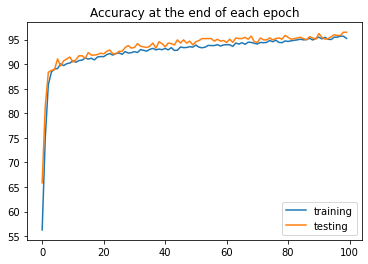

In [102]:
plt.plot([x/(len(train_idx)/100) for x in np.array(train_correct)], label='training')
plt.plot([x/(len(test_idx)/100) for x in np.array(test_correct)], label='testing')
plt.title('Accuracy at the end of each epoch')
plt.legend()

In [104]:
torch.save(CNNmodel.state_dict(), 'siec_od_0_95%_lr_00001_ep100.pt')

In [24]:
model = ConvolutionalNetwork()
model.load_state_dict(torch.load('siec_od_0_95%_lr_00001_ep100.pt'))

<All keys matched successfully>

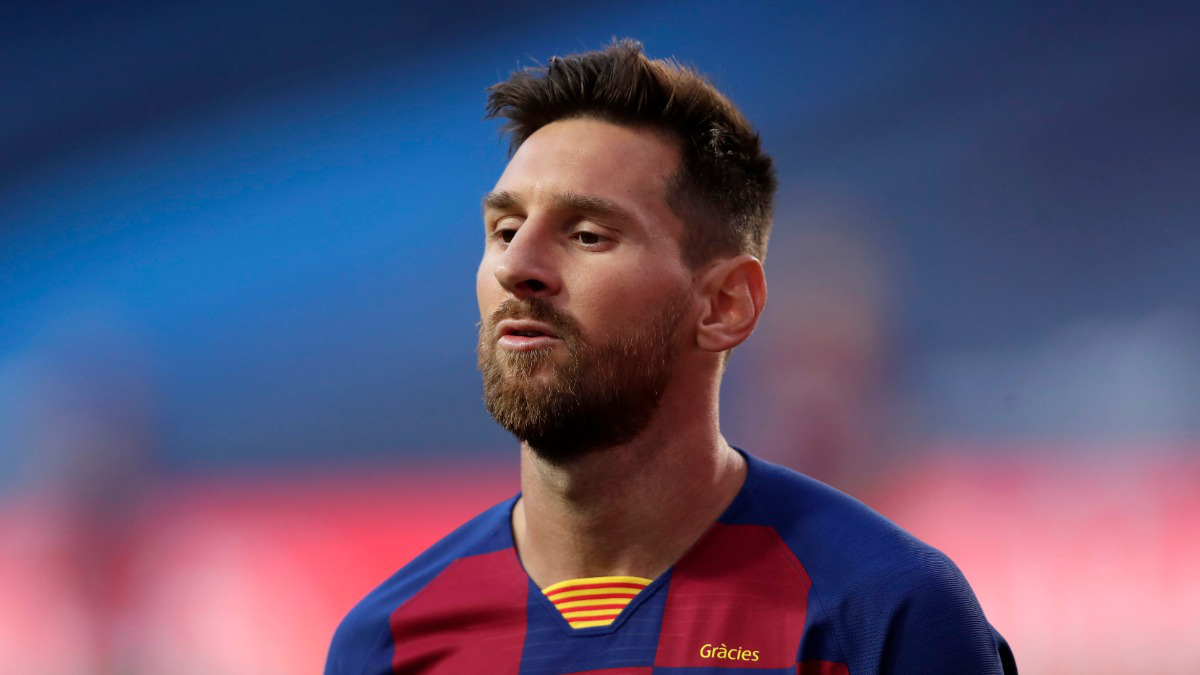

In [25]:
from PIL import Image
image = Image.open('./test_new_data/Messi_without_mask.jpg')
image

In [26]:
image = test_transform(image)
image = image.unsqueeze(0) # adding the 'batch dimension'

with torch.no_grad():
    output = model(image)
    print(output)
pos = output[0].argmax()
print(pos)
class_names[pos]

tensor([[-0.0168, -4.0948]])
tensor(0)


'with_mask'

In [129]:
class_names

['with_mask', 'without_mask']

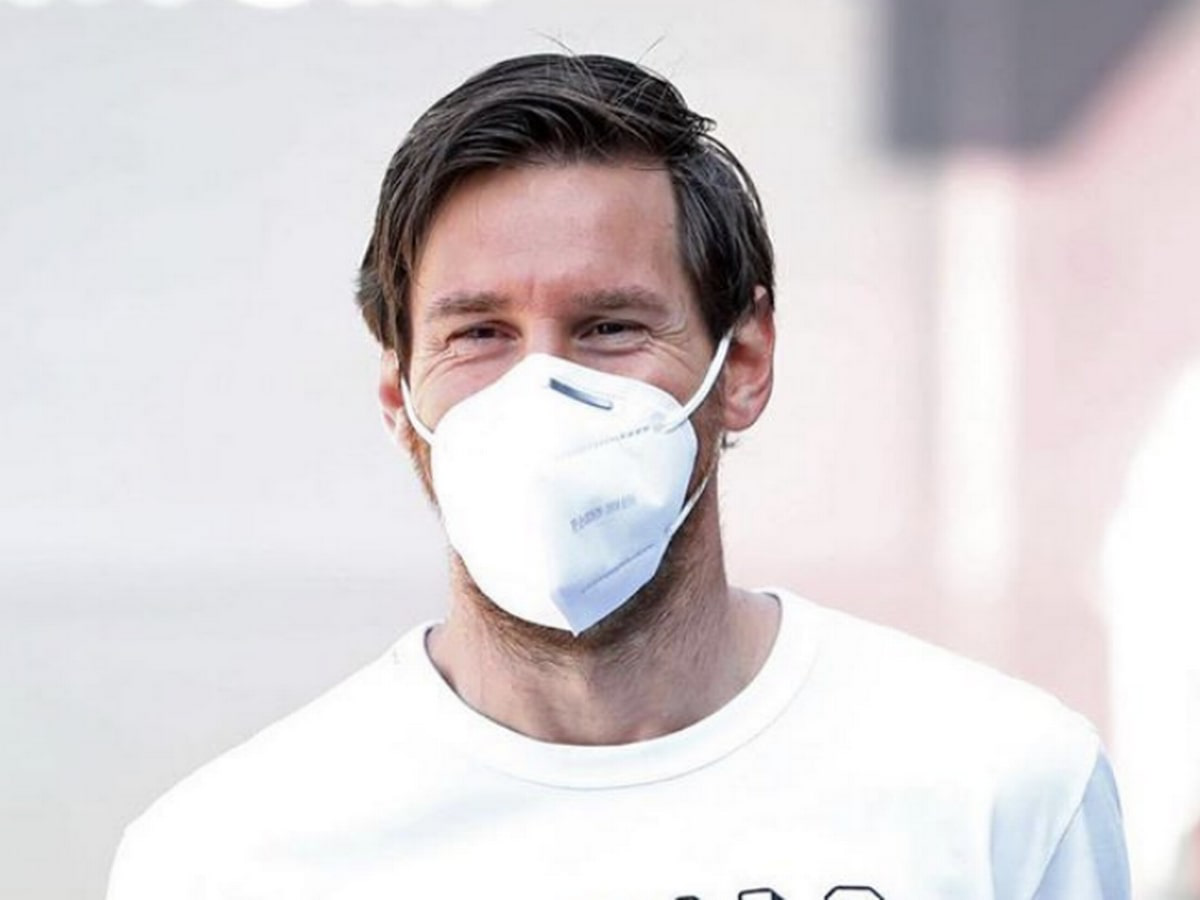

In [27]:
from PIL import Image
image = Image.open('./test_new_data/messi_mask.jpg')
image

In [28]:
image = test_transform(image)
image = image.unsqueeze(0) # adding the 'batch dimension'

with torch.no_grad():
    output = model(image)
    print(output)
pos = output[0].argmax()
print(pos)
class_names[pos]

tensor([[-0.0174, -4.0575]])
tensor(0)


'with_mask'

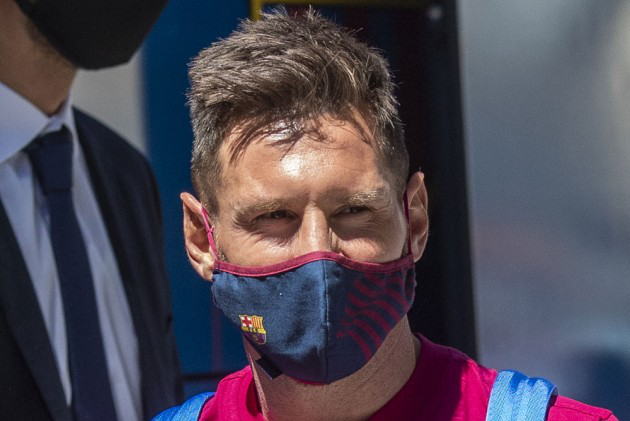

In [29]:
from PIL import Image
image = Image.open('./test_new_data/Messi_with_mask.jpg')
image

In [30]:
image = test_transform(image)
image = image.unsqueeze(0) # adding the 'batch dimension'

with torch.no_grad():
    output = model(image)
    print(output)
pos = output[0].argmax()
print(pos)
class_names[pos]

tensor([[-1.0483, -0.4316]])
tensor(1)


'without_mask'

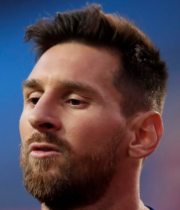

In [31]:
from PIL import Image
image = Image.open('./test_new_data/Untitled.png').convert('RGB')
image

In [32]:
image = test_transform(image)
image = image.unsqueeze(0) # adding the 'batch dimension'

with torch.no_grad():
    output = model(image)
    print(output)
pos = output[0].argmax()
print(pos)
class_names[pos]

tensor([[-4.6710, -0.0094]])
tensor(1)


'without_mask'

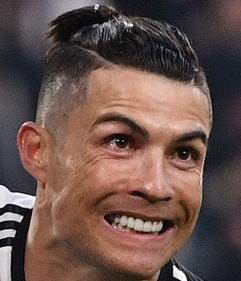

In [138]:
from PIL import Image
image = Image.open('./test_new_data/Ronaldo_without_mask_face.jpg')
image

In [139]:
image = test_transform(image)
image = image.unsqueeze(0) # adding the 'batch dimension'

with torch.no_grad():
    output = model(image)
    print(output)
pos = output[0].argmax()
print(pos)
class_names[pos]

tensor([[-3.6258, -0.0270]])
tensor(1)


'without_mask'